# Deutsch-Jozsa Algorithm

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
qml.drawer.use_style(style='sketch')

**Balanced or constant? (for multivariable binary function)**

Consider a multivariate binary function $f$ defined as follows:

$$
f: \{0,1\}^n \rightarrow \{0,1\}
$$

There are $2^n$ possible inputs and so that $2^{2^n}$ possible functions.

We want to determine whether the function is constant or balanced (1/2 of the outputs are 0 and 1/2 are 1).
How many times do we need to evaluate the function to determine this?

## Classical Solution

In [3]:
def is_constant(f, n:int):
    # Generate all possible inputs
    inputs = [bin(i)[2:].zfill(n) for i in range(2**n)]
    inputs = list(map(lambda x: list(map(int, [*x])), inputs))

    return all([f(x) == f(inputs[0]) for x in inputs])

In [4]:
# Worst case scenario
def f(x):
    return 0

In [5]:
import timeit

def query_complexity(n):
    times = []
    for i in range(1, n+1):
        start = timeit.default_timer()
        is_constant(f, i)
        stop = timeit.default_timer()
        times.append(stop - start)
    return times

In [6]:
classical_times = query_complexity(10)

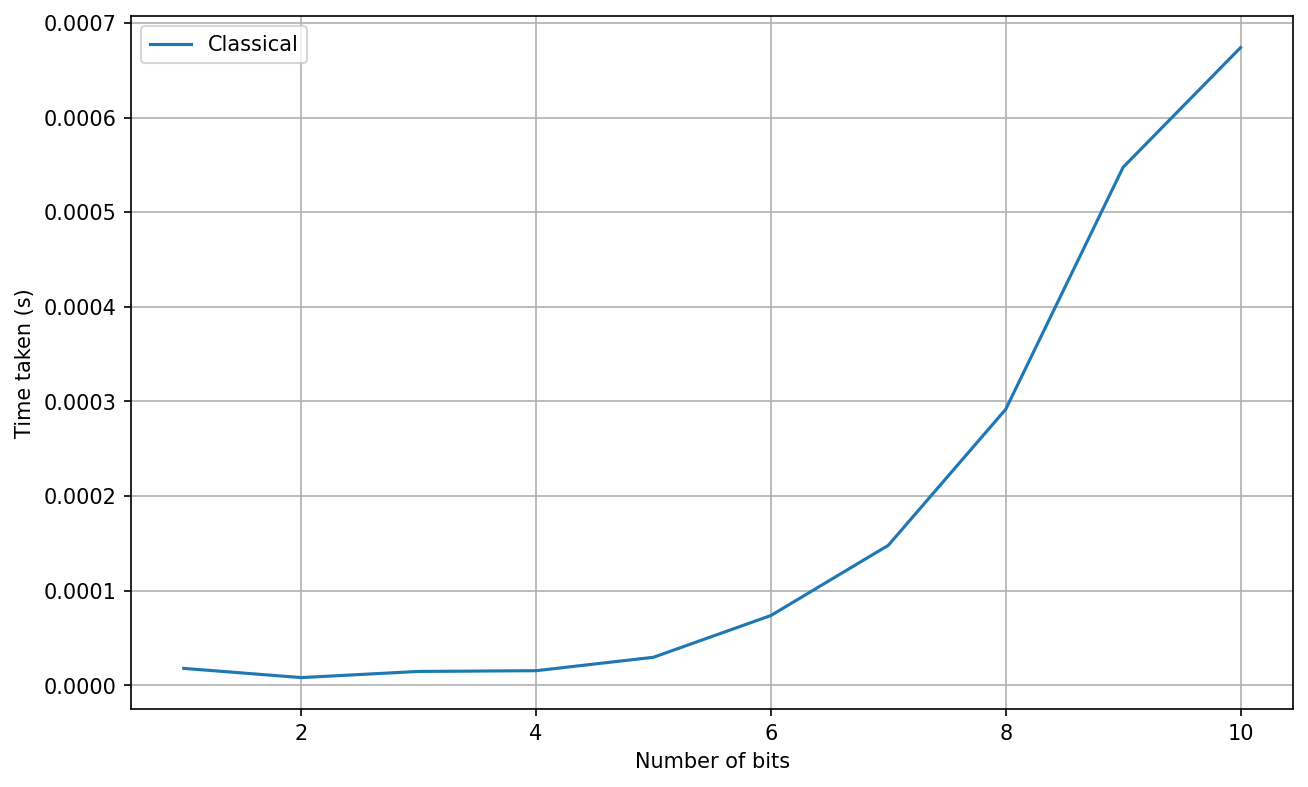

In [7]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(range(1, 11), classical_times, label='Classical')
plt.xlabel('Number of bits')
plt.ylabel('Time taken (s)')
plt.legend()
plt.grid()
plt.show()

## Quantum Solution

Consider the unitary operator $U_f$ defined as follows:

$$
U_f(|x_0\rangle \otimes \cdots \otimes |x_{n-1}\rangle \otimes |y\rangle) = |x_0\rangle \otimes \cdots \otimes |x_{n-1}\rangle \otimes |y \oplus f(x_0, \cdots, x_{n-1})\rangle
$$

For example, suppose $n=2$. With computational basis, the unitary operator $U_f$ is represented as follows:

- `000 = [1,0,0,0,0,0,0,0] -> [1,0,0,0,0,0,0,0] if f(00)=0 else [0,1,0,0,0,0,0,0]`
- `001 = [0,1,0,0,0,0,0,0] -> [0,1,0,0,0,0,0,0] if f(01)=0 else [1,0,0,0,0,0,0,0]`
- ...

In [8]:
def U(f, n):
    # Generate all possible inputs
    inputs = [bin(i)[2:].zfill(n) for i in range(2**n)]
    inputs = list(map(lambda x: list(map(int, [*x])), inputs))

    # Generate the unitary matrix
    unitary = np.eye(2**(n+1))
    for i in range(2**n):
        index = 2 * i
        unitary[index,     index] = 1 - f(*inputs[i])
        unitary[index,   index+1] = f(*inputs[i])
        unitary[index+1,   index] = f(*inputs[i])
        unitary[index+1, index+1] = 1 - f(*inputs[i])
    
    return unitary

In [9]:
def gen_balanced_function(n):
    y = np.random.randint(2, size=2**(n-1))
    y_bar = 1 - y
    y = np.concatenate((y, y_bar))
    np.random.shuffle(y)
    def f(*x):
        number = 0
        for i in range(n):
            number += 2**(n-i-1) * x[i]
        return y[number]
    return f

def gen_constant_function(n):
    y = np.random.randint(2)
    def f(*x):
        return y
    return f

In [10]:
f1 = gen_balanced_function(2)
f2 = gen_constant_function(2)

In [11]:
print(U(f1, 2))
print(U(f2, 2))

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [12]:
def gen_deutsch_jozsa(n:int):
    dev = qml.device('default.qubit', wires=n+1)
    @qml.qnode(dev)
    def circuit(f):
        # Apply X gate to the last qubit to make the state |1>
        qml.PauliX(wires=n)

        # Add barrier to separate input state from rest of circuit
        qml.Barrier(wires=range(n+1))

        # Apply Hadamard gates to all qubits
        for i in range(n+1):
            qml.Hadamard(wires=i)

        # Apply U_f
        qml.QubitUnitary(U(f, n), wires=range(n+1))

        # Apply Hadamard gates to all qubits
        for i in range(n):
            qml.Hadamard(wires=i)
        
        # Measure all qubits
        return qml.probs(wires=range(n))
    return dev, circuit

In [13]:
dev, circuit = gen_deutsch_jozsa(2)

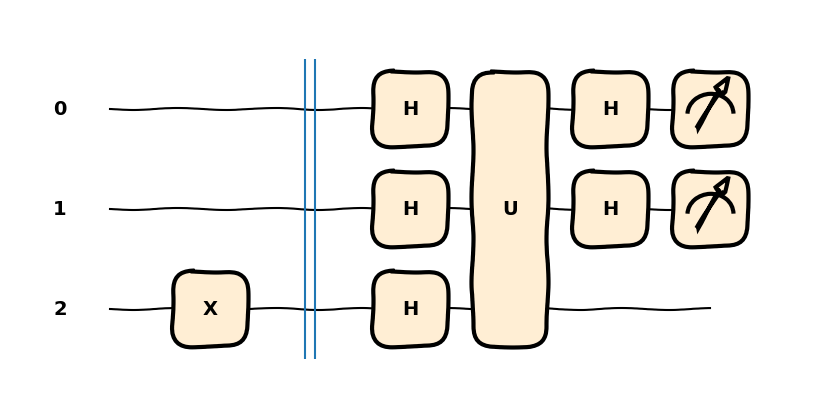

In [14]:
qml.draw_mpl(circuit)(f1)
plt.show()

**Walsh-Hadamard transformation**

To understand above circuit, we need to understand the Walsh-Hadamard transformation.

Consider the following unitary operator $W$ defined as follows:
$$
W = H^{\otimes n} = H \otimes \cdots \otimes H
$$
where $H$ is the Hadamard gate.

Let apply $W$ to the $n$-qubit state $|x\rangle$:
$$
\begin{aligned}
W|x\rangle &= H^{\otimes n}|x\rangle = H|x_0\rangle \otimes \cdots \otimes H|x_{n-1}\rangle \\
&= \frac{1}{\sqrt{2}}(|0\rangle + (-1)^{x_0}|1\rangle) \otimes \cdots \otimes \frac{1}{\sqrt{2}}(|0\rangle + (-1)^{x_{n-1}}|1\rangle) \\
&= \frac{1}{\sqrt{2^n}}\sum_{y=0}^{2^n-1}(-1)^{x_0y_0 + \cdots + x_{n-1}y_{n-1}}|y\rangle \\
&= \frac{1}{\sqrt{2^n}}\sum_{y=0}^{2^n-1}(-1)^{x \cdot y}|y\rangle
\end{aligned}
$$

**Explanation of the circuit**

1) Apply X gate to the last qubit (the ancilla qubit) to make it |1>

2) Apply Hadamard gates to all qubits
    $$
    |0\rangle^{\otimes n} \otimes |1\rangle \xrightarrow{H^{\otimes n+1}} \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
    $$
    Here, $|x\rangle$ denotes $x$-th computational basis state.

3) Apply $U_f$
    $$
    \begin{aligned}
    \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) &\xrightarrow{U_f} \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle \otimes \frac{1}{\sqrt{2}}(|f(x)\rangle - |1 \oplus f(x)\rangle) \\
    &= \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
    \end{aligned}
    $$
    Thus, first $n$ qubits and the ancilla qubit are decoupled.

4) Apply Hadamard gates to first $n$ qubits
    $$
    \begin{aligned}
    \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle \xrightarrow{H^{\otimes n}} &\frac{1}{2^n} \sum_{x=0}^{2^n-1} \sum_{y=0}^{2^n-1} (-1)^{f(x)} (-1)^{x \cdot y} |y\rangle \\
    &= \frac{1}{2^n} \sum_{y=0}^{2^n-1} \left( \sum_{x=0}^{2^n-1} (-1)^{f(x) + x \cdot y} \right) |y\rangle
    \end{aligned}
    $$

5) Measure first $n$ qubits to obtain $P(|y\rangle = |0\rangle^{\otimes n})$
    $$
    P(|y\rangle = |0\rangle^{\otimes n}) = \left| \frac{1}{2^n} \sum_{x=0}^{2^n-1} (-1)^{f(x)} \right|^2
    $$
    - If $f$ is constant, then $P(|y\rangle = |0\rangle^{\otimes n}) = 1$.

    - If $f$ is balanced, then $P(|y\rangle = |0\rangle^{\otimes n}) = 0$.

    - If $f$ is neither constant nor balanced, then $P(|y\rangle = |0\rangle^{\otimes n}) \in (0,1)$.
        

In [15]:
def is_equal(a:float, b:float, rtol:float=1e-5):
    return abs(a-b) <= rtol * max(abs(a), abs(b))

In [16]:
n = 3

dev, circuit = gen_deutsch_jozsa(3)

f_b = gen_balanced_function(n)
f_c = gen_constant_function(n)

dj_b = circuit(f_b)
dj_c = circuit(f_c)

f_b_is_constant = is_equal(dj_b[0], 1.0)
f_c_is_constant = is_equal(dj_c[0], 1.0)

print("For a balanced function, the algorithm predicts that it is constant: ", f_b_is_constant)
print("For a constant function, the algorithm predicts that it is constant: ", f_c_is_constant)

For a balanced function, the algorithm predicts that it is constant:  False
For a constant function, the algorithm predicts that it is constant:  True


In [17]:
def query_complexity_quantum_constant(n):
    times = []
    for i in range(1, n+1):
        dev, circuit = gen_deutsch_jozsa(i)
        f = gen_constant_function(i)
        start = timeit.default_timer()
        dj = circuit(f)
        is_equal(dj[0], 1.0)
        stop = timeit.default_timer()
        times.append(stop - start)
    return times

In [18]:
quantum_times = query_complexity_quantum_constant(10)

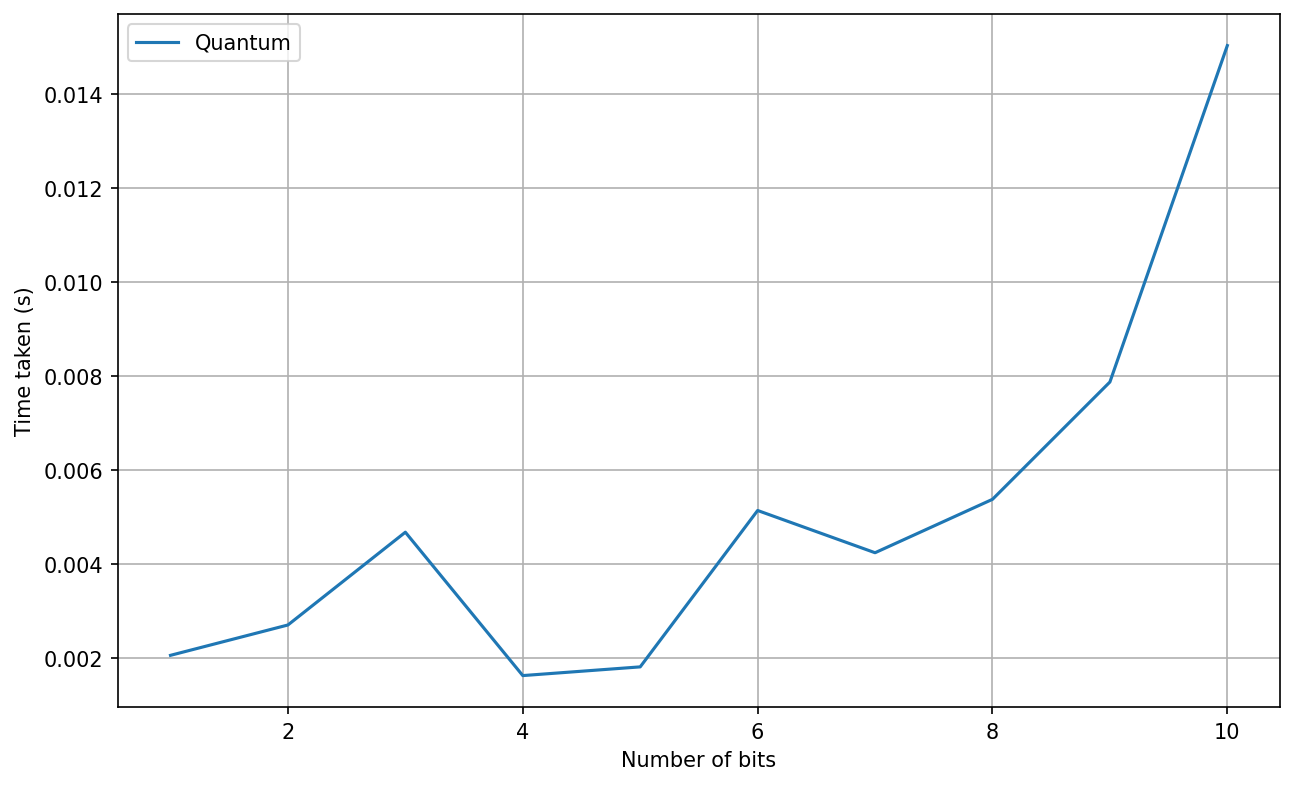

In [19]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(range(1, 11), quantum_times, label='Quantum')
plt.xlabel('Number of bits')
plt.ylabel('Time taken (s)')
plt.legend()
plt.grid()
plt.show()

### Run with IBM Quantum Experience

In [20]:
# def gen_deutsch_jozsa(n:int):
#     dev = qml.device('qiskit.ibmq', wires=n+1, backend='ibmq_qasm_simulator')
#     @qml.qnode(dev)
#     def circuit(f):
#         # Apply X gate to the last qubit to make the state |1>
#         qml.PauliX(wires=n)

#         # Add barrier to separate input state from rest of circuit
#         qml.Barrier(wires=range(n+1))

#         # Apply Hadamard gates to all qubits
#         for i in range(n+1):
#             qml.Hadamard(wires=i)

#         # Apply U_f
#         qml.QubitUnitary(U(f, n), wires=range(n+1))

#         # Apply Hadamard gates to all qubits
#         for i in range(n):
#             qml.Hadamard(wires=i)
        
#         # Measure all qubits
#         return qml.probs(wires=range(n))
#     return dev, circuit

In [21]:
# def query_complexity_quantum_constant(n):
#     times = []
#     for i in range(1, n+1):
#         dev, circuit = gen_deutsch_jozsa(i)
#         f = gen_constant_function(i)
#         start = timeit.default_timer()
#         dj = circuit(f)
#         is_equal(dj[0], 1.0, 1e-1)
#         stop = timeit.default_timer()
#         times.append(stop - start)
#     return times

In [22]:
# quantum_times = query_complexity_quantum_constant(10)

In [23]:
quantum_times = [
    0.005485967,
    0.002162124,
    0.004567849,
    0.003109943,
    0.003303143,
    0.092140306,
    0.010469479,
    0.002274819,
    0.003467794
]

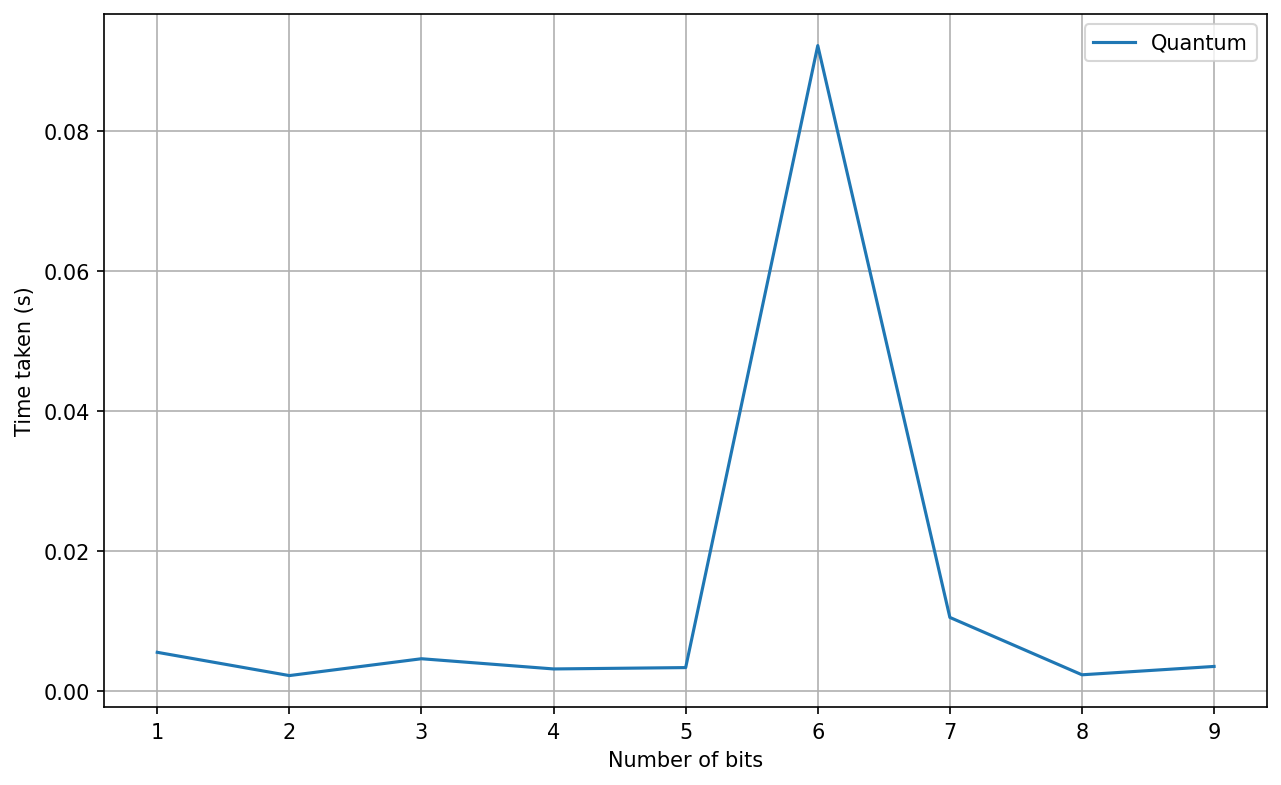

In [24]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(range(1, 10), quantum_times, label='Quantum')
plt.xlabel('Number of bits')
plt.ylabel('Time taken (s)')
plt.legend()
plt.grid()
plt.show()